# Projecting Growth of Coronavirus Cases in the U.S.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
sns.set(style='darkgrid')

In [2]:
%matplotlib inline

## Johns Hopkins Coronavirus Dataset

In [3]:
# Johns Hopkins COVID-19 time series datasets on GitHub
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
data_dir = 'csse_covid_19_data/csse_covid_19_time_series/'
source_url = base_url + data_dir

# Global Cases/Deaths/Recovered by country
cases_csv = 'time_series_covid19_confirmed_global.csv'
deaths_csv = 'time_series_covid19_deaths_global.csv'
recovered_csv = 'time_series_covid19_recovered_global.csv'

# Full URLs to datasets
cases_url = source_url + cases_csv
deaths_url = source_url + deaths_csv
recovered_url = source_url + recovered_csv

## Confirmed Cases

In [4]:
# Global Confirmed Cases
cases_global = pd.read_csv(cases_url, index_col='Country/Region').drop(
    columns=['Province/State', 'Lat', 'Long'])

# US Confirmed Cases
cases_US = cases_global.loc['US']
cases_US = pd.DataFrame(data=cases_US)
cases_US = cases_US.reset_index()
cases_US = cases_US.rename(columns={'US': 'infected', 'index':'date'})
cases_US.tail(5)

,date,infected
61,3/23/20,43847
62,3/24/20,53740
63,3/25/20,65778
64,3/26/20,83836
65,3/27/20,101657


## Curve Fitting

In [5]:
# Fill in (zeros) data through Jan 21, then add US cases
ydata = [0] * 21
ydata.extend(cases_US['infected'].tolist())
xdata = np.arange(len(ydata))

# Get the day of the year for today
today = len(ydata) - 1

# Get the date for the most recent entry
latest = cases_US.loc[len(cases_US)-1,'date']

In [6]:
# Number of Cases (Gompertz function)
# https://elm.nsupdate.info/maths.html
def N(x, d, T2, Nmax):
    return Nmax * np.exp( -np.exp( -np.log(2) / T2 * (x-d) ) )

In [7]:
# SciPy curve fit
popt, pcov = curve_fit(N, xdata, ydata)

print("d={:4.3f}, T2={:4.3f}, Nmax={:4.3e}".format(*tuple(popt)))

d=103.616, T2=10.986, Nmax=2.120e+06


## Projected COVID Cases, USA

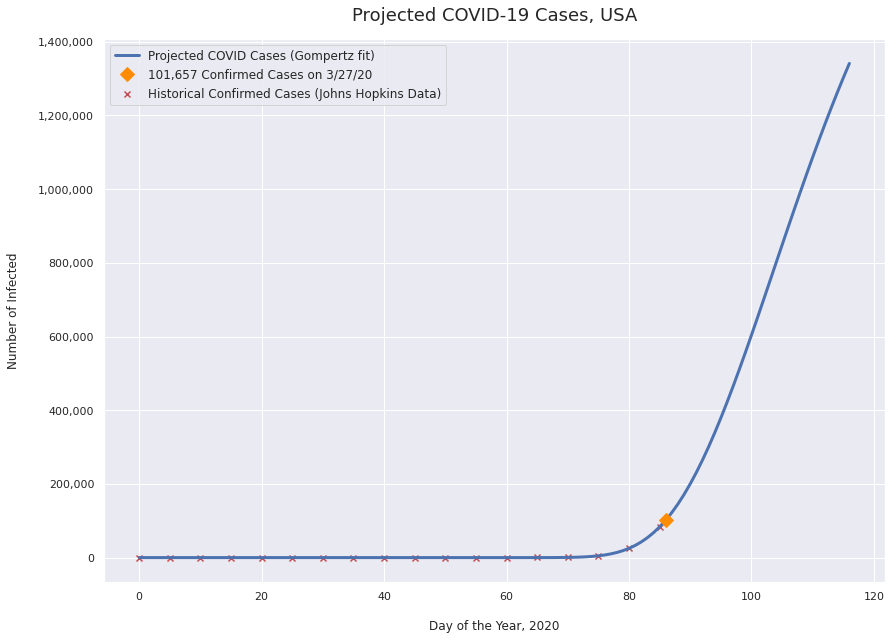

In [29]:
# Set up the figure
f = plt.figure(figsize=(14,10))
plt.xlabel('Day of the Year, 2020', labelpad=18)
plt.ylabel('Number of Infected', labelpad=18)
plt.title("Projected COVID-19 Cases, USA", fontsize=18, pad=18)

# Plot the Gompertz fit for previous cases, plus project 30 days ahead
days = np.arange(len(xdata) + 30)
plt.plot(days, N(days, *popt), '-', lw=3, label='Projected COVID Cases (Gompertz fit)')

# Scatterplot every nth day of confirmed cases
n = 5
x, y = xdata[::n], ydata[::n]
plt.scatter(x, y, marker='x', color='r',
    label='Historical Confirmed Cases (Johns Hopkins Data)')

# Plot a point representing today's total cases
plt.plot(today, ydata[today], "D", color='darkorange', ms=10,
    label='{:,} Confirmed Cases on {}'.format(ydata[today], latest))

# Format y-axis labels with thousands separator
ax = plt.gca()
ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Show the figure with legend
ax.legend(loc='upper left', fontsize=12)
plt.show()

# Save the figure as PNG
f.savefig("covid-{}.png".format(latest.replace('/','.')), dpi=400)